## GymTaxi environment RL training 

In [2]:
#initial libs
from IPython import display
import gym
assert gym.__version__ == '0.26.2'
import numpy as np
import matplotlib.pyplot as plt
from time import sleep

%matplotlib inline

In [3]:
#create environment
env = gym.make("Taxi-v3",render_mode="rgb_array")

### Description

There are four designated pick-up and drop-off locations (Red, Green, Yellow and Blue) in the 5x5 grid world. The taxi starts off at a random square and the passenger at one of the designated locations.

The goal is move the taxi to the passenger’s location, pick up the passenger, move to the passenger’s desired destination, and drop off the passenger. Once the passenger is dropped off, the episode ends.

The player receives positive rewards for successfully dropping-off the passenger at the correct location. Negative rewards for incorrect attempts to pick-up/drop-off passenger and for each step where another reward is not received.

#### Action Space

The action shape is (1,) in the range {0, 5} indicating which direction to move the taxi or to pickup/drop off passengers.

<ul>
<li>0: Move south (down)</li>
<li>1: Move north (up)</li>
<li>2: Move east (right)</li>
<li>3: Move west (left)</li>
<li>4: Pickup passenger</li>
<li>5: Drop off passenger</li>
</ul>    

#### Observation Space

There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations.
Destination on the map are represented with the first letter of the color.
Passenger locations:
<ul>
<li>0: Red</li>
<li>1: Green</li>
<li>2: Yellow</li>
<li>3: Blue</li>
<li>4: In taxi</li>
</ul>
Destinations:
<ul>
<li>0: Red</li>
<li>1: Green</li>
<li>2: Yellow</li>
<li>3: Blue</li>
</ul>

#### Starting State
The episode starts with the player in a random state.

#### Rewards
<ul>
<li>-1 per step unless other reward is triggered.</li>
<li>+20 delivering passenger.</li>
<li>-10 executing “pickup” and “drop-off” actions illegally.</li>
</ul>

An action that results a noop, like moving into a wall, will incur the time step penalty. Noops can be avoided by sampling the action_mask returned in info.

#### Episode End
The episode ends if the following happens:
Termination: 1. The taxi drops off the passenger.
Truncation (when using the time_limit wrapper): 1. The length of the episode is 200.


### Implement Policy Iteration approach to train the agent

![policy evaluation](p_eval.png)

In [9]:
#evaluate V function 
def policy_evaluation(policy, environment, discount_factor=1.0, theta=1e-9, max_iterations=1e9):
    # Number of evaluation iterations
    evaluation_iterations = 1
    # Initialize a value function for each state as zero
    V = np.zeros(environment.observation_space.n)
    # Repeat until change in value is below the threshold
    for i in range(int(max_iterations)):
        # Initialize a change of value function as zero
        delta = 0
        # Iterate though each state
        for state in range(environment.observation_space.n):
           # Initial a new value of current state
           v = 0
           # Try all possible actions which can be taken from this state
           for action, action_probability in enumerate(policy[state]):
             # Check how good next state will be
             for state_probability, next_state, reward, terminated in environment.P[state][action]:
                  # Calculate the expected value
                  v += action_probability * state_probability * (reward + discount_factor * V[next_state])

           # Calculate the absolute change of value function
           delta = max(delta, np.abs(V[state] - v))
           # Update value function
           V[state] = v
        evaluation_iterations += 1

        # Terminate if value change is insignificant
        if delta < theta:
            print(f'Policy evaluated in {evaluation_iterations} iterations.')
            return V

In [8]:
#get q function for possible actions from current state
def one_step_lookahead(environment, state, V, discount_factor):
    action_values = np.zeros(environment.action_space.n)
    for action in range(environment.action_space.n):
        for probability, next_state, reward, terminated in environment.P[state][action]:
            action_values[action] += probability * (reward + discount_factor * V[next_state])
    return action_values

In [10]:
#iterate evaluation and improvement pahses
def policy_iteration(environment, discount_factor=1.0, max_iterations=1e9):
    # Start with a random policy
    #num states x num actions / num actions
    policy = np.ones([environment.observation_space.n, environment.action_space.n]) / environment.action_space.n
    # Initialize counter of evaluated policies
    evaluated_policies = 1
    # Repeat until convergence or critical number of iterations reached
    for i in range(int(max_iterations)):
        stable_policy = True
        # Evaluate current policy
        V = policy_evaluation(policy, environment, discount_factor=discount_factor)
        # Go through each state and try to improve actions that were taken (policy Improvement)
        for state in range(environment.observation_space.n):
            # Choose the best action in a current state under current policy
            current_action = np.argmax(policy[state])
            # Look one step ahead and evaluate if current action is optimal
            # We will try every possible action in a current state
            action_value = one_step_lookahead(environment, state, V, discount_factor)
            # Select a better action
            best_action = np.argmax(action_value)
            # If action didn't change
            if current_action != best_action:
                stable_policy = False
                # Greedy policy update
                policy[state] = np.eye(environment.action_space.n)[best_action]
        evaluated_policies += 1
        # If the algorithm converged and policy is not changing anymore, then return final policy and value function
        if stable_policy:
            print(f'Evaluated {evaluated_policies} policies.')
            return policy, V

### Play the episodes

In [11]:
#this method will play N episodes
def play_episodes(environment, n_episodes, policy):
    wins = 0
    total_reward = 0
    for episode in range(n_episodes):
        terminated = False
        state, _ = environment.reset()
        while not terminated:
            # Select best action to perform in a current state
            action = np.argmax(policy[state])
            # Perform an action an observe how environment acted in response
            next_state, reward, terminated, info, _ = environment.step(action)
            # Summarize total reward
            total_reward += reward
            # Update current state
            state = next_state
            # Calculate number of wins over episodes
            if terminated and reward == 20.0:
                wins += 1
    average_reward = total_reward / n_episodes
    return wins, total_reward, average_reward

In [12]:
#let's try to get optimal policy
policy, V = policy_iteration(env, discount_factor=0.98)

Policy evaluated in 858 iterations.
Policy evaluated in 1028 iterations.
Policy evaluated in 1028 iterations.
Policy evaluated in 1028 iterations.
Policy evaluated in 1028 iterations.
Policy evaluated in 1028 iterations.
Policy evaluated in 1028 iterations.
Policy evaluated in 1028 iterations.
Policy evaluated in 1028 iterations.
Policy evaluated in 1028 iterations.
Policy evaluated in 1028 iterations.
Policy evaluated in 1028 iterations.
Policy evaluated in 600 iterations.
Policy evaluated in 600 iterations.
Evaluated 15 policies.


### Print the average wins and reward for 10000 episodes

In [14]:
n_episodes = 10000
wins, total_reward, average_reward = play_episodes(env, 10000, policy)
print(f'Number of wins over {n_episodes} episodes = {wins}')
print(f'Average reward over {n_episodes} episodes = {average_reward}')

Number of wins over 10000 episodes = 10000
Average reward over 10000 episodes = 7.7286


**All the episodes were successfull! This mean the policy evaluated correctly!**

### Visualize one episode

In [15]:
def visualize_epizode(env, policy, seed=132, many_frames=False):
    observation, info = env.reset(seed=seed)
    for i in range(env.spec.max_episode_steps):
        plt.imshow(env.render())
        display.display(plt.gcf())    
        if not many_frames:
            display.clear_output(wait=True)

        action = np.argmax(policy[observation])
        observation, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            break

        sleep(1)

    env.close()

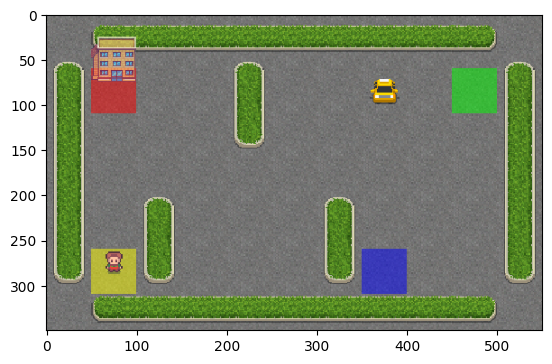

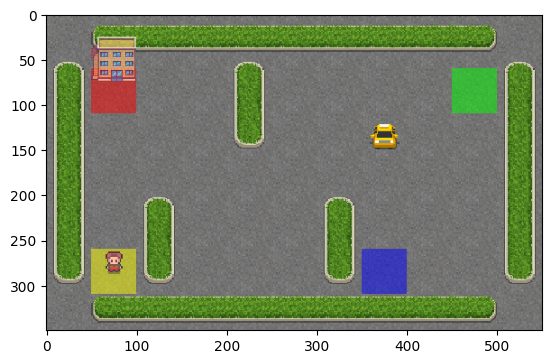

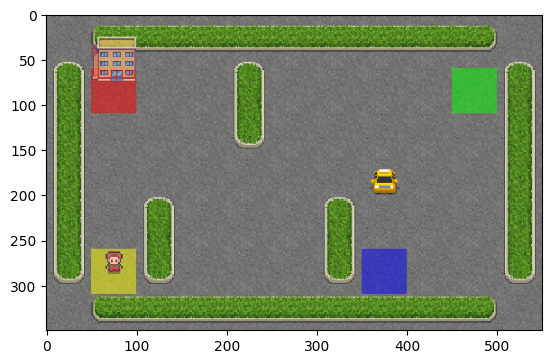

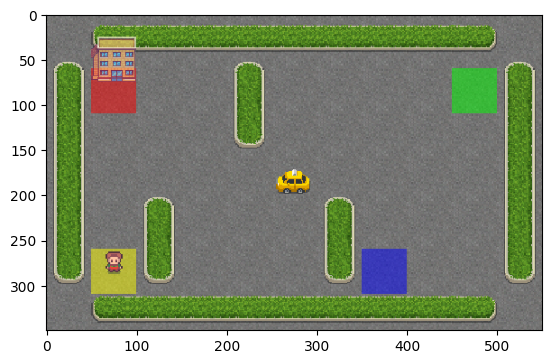

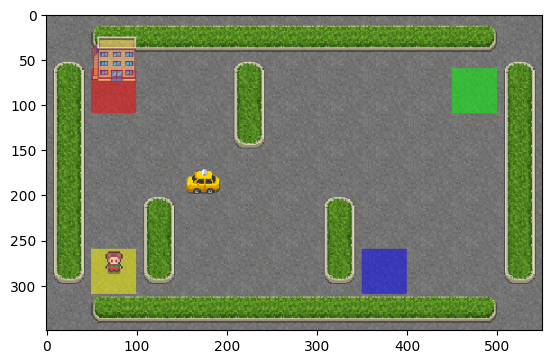

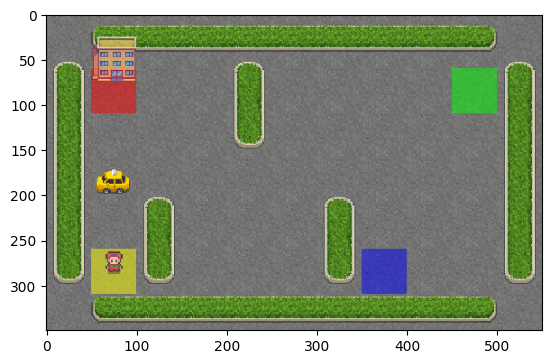

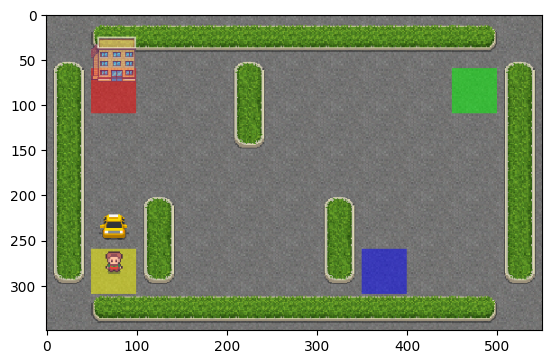

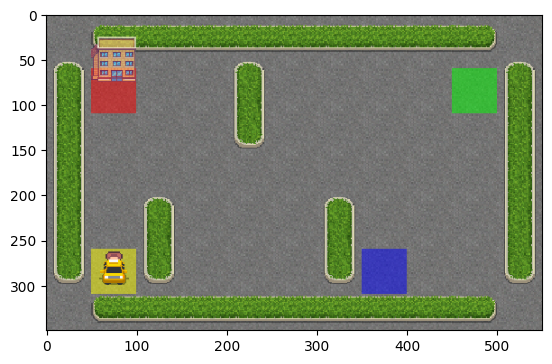

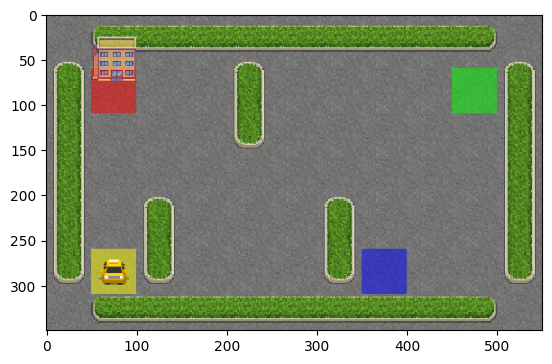

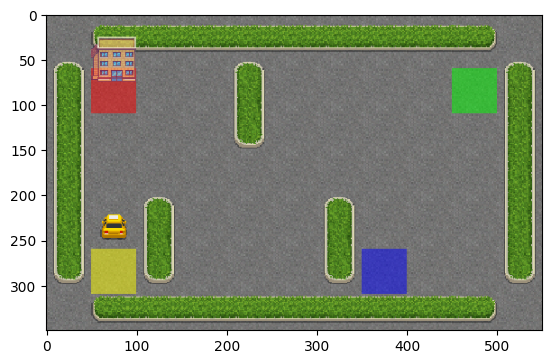

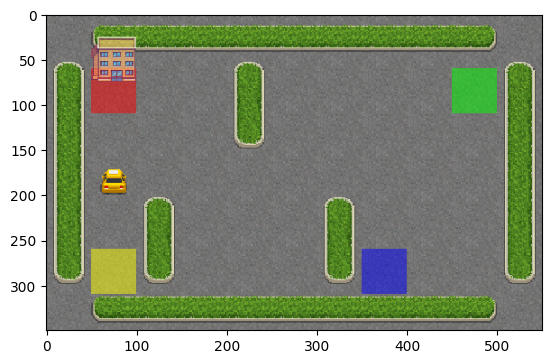

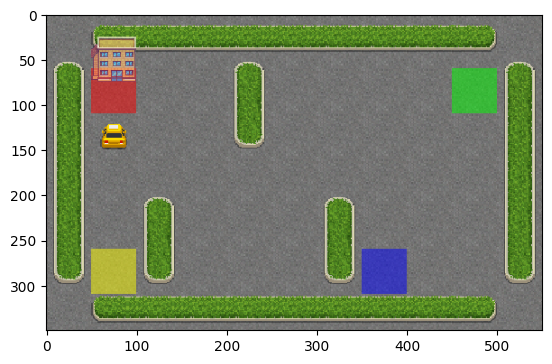

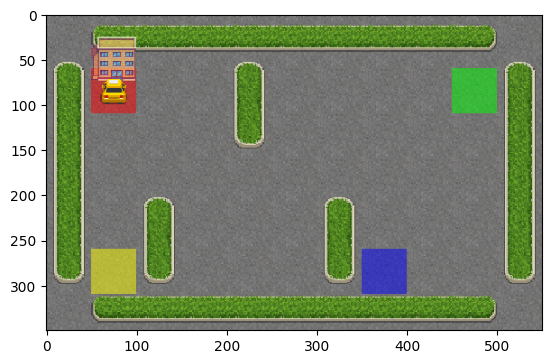

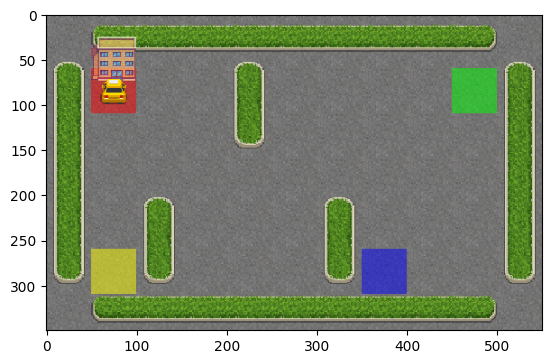

In [17]:
visualize_epizode(env, policy, many_frames=True)

**We can see that the taxi  really pick up the passenger and head to the final destination and drop off!**

If you would like to visualize dynamically in one frame, call visualize_epizode with many_frames=False

### RL is a power !!!!